# Data Processing

In this project, I processed the movie review dataset to prepare it for sentiment analysis. The goal was to clean, standardize, and convert the text data into a format suitable for machine learning models. The following steps were taken to achieve this:


In [9]:
# Import Libraries
import pandas as pd
import numpy as np
import pickle
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Download NLTK data files
#nltk.download('punkt_tab')
#nltk.download('stopwords')
#nltk.download('wordnet')
#nltk.download('omw-1.4')

## 1. Data Cleaning
- I removed HTML tags, special characters, and numbers from the reviews to eliminate noise. This was done using regular expressions to retain only alphabetic characters in the text.
- All text was converted to lowercase to ensure uniformity and prevent the model from treating words with different cases as separate entities (e.g., "Great" vs. "great").


In [2]:
# Load the dataset
data = pd.read_csv('../data/IMDB Dataset.csv')

# Text cleaning function
def clean_text(text):
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Convert to lowercase
    text = text.lower()
    return text

# Apply the cleaning function to the review column
data['cleaned_review'] = data['review'].apply(clean_text)

# Display the first few cleaned reviews
print(data[['review', 'cleaned_review']].head())

                                              review  \
0  One of the other reviewers has mentioned that ...   
1  A wonderful little production. <br /><br />The...   
2  I thought this was a wonderful way to spend ti...   
3  Basically there's a family where a little boy ...   
4  Petter Mattei's "Love in the Time of Money" is...   

                                      cleaned_review  
0  one of the other reviewers has mentioned that ...  
1  a wonderful little production the filming tech...  
2  i thought this was a wonderful way to spend ti...  
3  basically theres a family where a little boy j...  
4  petter matteis love in the time of money is a ...  


## 2. Tokenization
I then split each cleaned review into individual words (tokens) using NLTK’s word tokenizer. This step helped us break down each review into a list of words, making it easier to manipulate and analyze.


In [3]:
# Tokenize the cleaned reviews
data['tokens'] = data['cleaned_review'].apply(word_tokenize)

# Display the first few tokenized reviews
print(data[['cleaned_review', 'tokens']].head())

                                      cleaned_review  \
0  one of the other reviewers has mentioned that ...   
1  a wonderful little production the filming tech...   
2  i thought this was a wonderful way to spend ti...   
3  basically theres a family where a little boy j...   
4  petter matteis love in the time of money is a ...   

                                              tokens  
0  [one, of, the, other, reviewers, has, mentione...  
1  [a, wonderful, little, production, the, filmin...  
2  [i, thought, this, was, a, wonderful, way, to,...  
3  [basically, theres, a, family, where, a, littl...  
4  [petter, matteis, love, in, the, time, of, mon...  


## 3. Stop Words Removal
Then I removed common stop words such as "the", "is", "and", etc., using NLTK’s built-in stop word list. Stop words generally do not contribute much to sentiment classification, so removing them helped to reduce noise and improve the quality of the features.


In [4]:
# Set of English stop words
stop_words = set(stopwords.words('english'))

# Function to remove stop words
def remove_stopwords(tokens):
    return [word for word in tokens if word not in stop_words]

# Apply stop words removal to the tokens
data['tokens_no_stopwords'] = data['tokens'].apply(remove_stopwords)

# Display the first few tokenized reviews without stop words
print(data[['tokens', 'tokens_no_stopwords']].head())

                                              tokens  \
0  [one, of, the, other, reviewers, has, mentione...   
1  [a, wonderful, little, production, the, filmin...   
2  [i, thought, this, was, a, wonderful, way, to,...   
3  [basically, theres, a, family, where, a, littl...   
4  [petter, matteis, love, in, the, time, of, mon...   

                                 tokens_no_stopwords  
0  [one, reviewers, mentioned, watching, oz, epis...  
1  [wonderful, little, production, filming, techn...  
2  [thought, wonderful, way, spend, time, hot, su...  
3  [basically, theres, family, little, boy, jake,...  
4  [petter, matteis, love, time, money, visually,...  


## 4. Lemmatization
Afterwards I applied lemmatization using NLTK’s WordNetLemmatizer to reduce each word to its base dictionary form, considering its context and part of speech. For example, "running" was converted to "run", and "better" was converted to "good". Lemmatization helped standardize words while preserving their true meaning and context, which is crucial for sentiment analysis.


In [5]:
# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

# Function to apply lemmatization
def lemmatize_words(tokens):
    return [lemmatizer.lemmatize(word) for word in tokens]

# Apply lemmatization to the tokens without stop words
data['lemmatized_tokens'] = data['tokens_no_stopwords'].apply(lemmatize_words)

# Display the first few lemmatized reviews
print(data[['tokens_no_stopwords', 'lemmatized_tokens']].head())

                                 tokens_no_stopwords  \
0  [one, reviewers, mentioned, watching, oz, epis...   
1  [wonderful, little, production, filming, techn...   
2  [thought, wonderful, way, spend, time, hot, su...   
3  [basically, theres, family, little, boy, jake,...   
4  [petter, matteis, love, time, money, visually,...   

                                   lemmatized_tokens  
0  [one, reviewer, mentioned, watching, oz, episo...  
1  [wonderful, little, production, filming, techn...  
2  [thought, wonderful, way, spend, time, hot, su...  
3  [basically, there, family, little, boy, jake, ...  
4  [petter, matteis, love, time, money, visually,...  


## 5. Final Cleaned Review Preparation
After lemmatization, the cleaned and lemmatized tokens were joined back together to form a final processed version of each review. This step was necessary to convert the list of tokens back into strings, which can be used for feature extraction.


In [6]:
# Join lemmatized tokens back into a single string for each review
data['final_review'] = data['lemmatized_tokens'].apply(lambda tokens: ' '.join(tokens))

# Initialize the TF-IDF Vectorizer
tfidf = TfidfVectorizer(max_features=5000)  # Limit to top 5000 features

# Fit and transform the data
X = tfidf.fit_transform(data['final_review'])

# Display the shape of the resulting TF-IDF matrix
print("TF-IDF Matrix Shape:", X.shape)

TF-IDF Matrix Shape: (50000, 5000)


# 6. Save the processed data

In [7]:
# Convert sentiment labels to binary values: 'positive' -> 1, 'negative' -> 0
data['sentiment'] = data['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)

# Save the TF-IDF matrix to a file (use a sparse matrix format for efficiency)
with open('../data/tfidf_matrix.pkl', 'wb') as file:
    pickle.dump(X, file)  # X is your TF-IDF matrix

# Save the labels to a file
np.save('../data/labels.npy', data['sentiment'].values)

print("Data preprocessing complete. TF-IDF matrix and labels saved.")

Data preprocessing complete. TF-IDF matrix and labels saved.


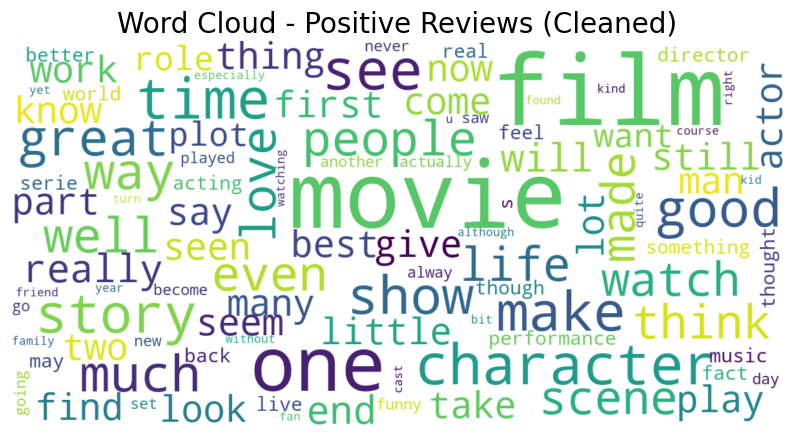

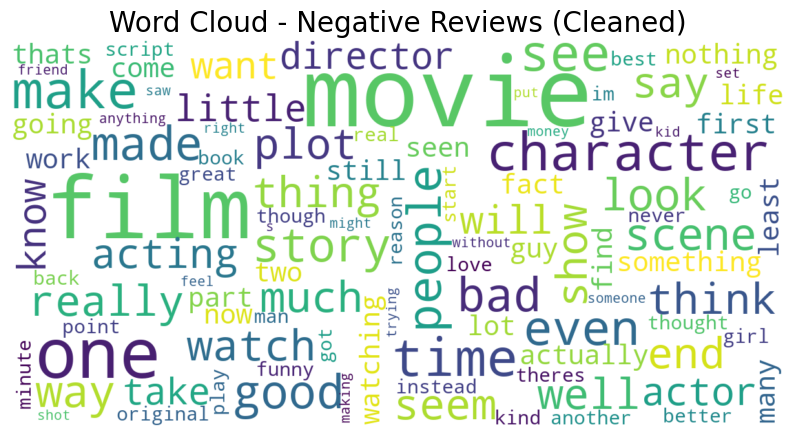

In [16]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

# Function to generate word cloud using the now processed data
def generate_wordcloud(text, title):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=STOPWORDS,
        max_words=100,
        max_font_size=50,
        scale=3,
        random_state=42
    ).generate(' '.join(text))
    
    # Display the word cloud
    plt.figure(figsize=(10, 7))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=20)
    plt.show()

# Generate word cloud for positive reviews using cleaned text
positive_reviews_cleaned = data[data['sentiment'] == 1]['cleaned_review']
generate_wordcloud(positive_reviews_cleaned, "Word Cloud - Positive Reviews (Cleaned)")

# Generate word cloud for negative reviews using cleaned text
negative_reviews_cleaned = data[data['sentiment'] == 0]['cleaned_review']
generate_wordcloud(negative_reviews_cleaned, "Word Cloud - Negative Reviews (Cleaned)")